## Model 2

In [1]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error


# Step 1 
## Compute Target values

The historic price and wind production data is used to determine what would have been the optimal bidding strategy in the energy market. The resuting passed optimal bids are used to build model 2. 

In [3]:
#Helping Method to limit the  
def ObservationPeriod(Start_Observation, End_Observation, data):
    Start_Observation = pd.to_datetime(Start_Observation)
    End_Observation = pd.to_datetime(End_Observation)
    condition = (data["HourDK"]>= Start_Observation) & (data["HourDK"]< End_Observation)
    data  = data[condition]
    return data

In [2]:
# p_t_hat as decision variable
def OptimizationProblemEnergybid(data):
    model = gp.Model()
    model.setParam('OutputFlag', 0)
    solutions  = list()
    capacity = 6000.0
    
    for index, row in data.iterrows():
        
        if pd.isnull(row[['p_t', 'DA_PriceEUR', 'BalancingPriceDownEUR', 'BalancingPriceUpEUR']]).any():
            continue
        
        p_t_hat = model.addVar(name="p_t_hat", lb=0, ub=capacity, vtype=GRB.INTEGER)
        z_down = model.addVar(name="z_down", vtype=GRB.CONTINUOUS, lb=0)
        z_up = model.addVar(name="z_up", vtype=GRB.CONTINUOUS, lb=0)
        
        condition_down = model.addVar(name="condition_down", vtype=GRB.BINARY)
        condition_up = model.addVar(name="condition_up", vtype=GRB.BINARY)
        
        model.addConstr(z_up <= (p_t_hat - row['p_t']) * condition_up)
        model.addConstr(z_up >= (p_t_hat - row['p_t']) * condition_up)
        model.addConstr(z_down <= (row['p_t'] - p_t_hat) * condition_down)
        model.addConstr(z_down >= (row['p_t'] - p_t_hat) * condition_down)
        model.addConstr(condition_up + condition_down == 1)
        
    
        #defining the constraints
        model.addConstr(-p_t_hat <= 0)
        model.addConstr(p_t_hat <= capacity)
        model.addConstr(-z_down <= 0)
        model.addConstr(-z_up <= 0)
        
        model.setObjective((row['DA_PriceEUR']*p_t_hat)+(row['BalancingPriceDownEUR']*z_down-row['BalancingPriceUpEUR']*z_up), GRB.MAXIMIZE)
        
        model.optimize()
    
        if model.status == GRB.OPTIMAL:
            
            values = {"Day-Ahead-Price": row['DA_PriceEUR'],
                      "BalancingPriceUp":row['BalancingPriceUpEUR'],
                      "BalancingPriceDown":row['BalancingPriceDownEUR'],
                      "p_t":row['p_t'],
                      "Revenue":model.ObjVal
                      }
            values.update({v.varName: v.x for v in model.getVars()})
        
            
            solutions.append({row['HourDK']:values})
                
        elif model.status == GRB.INFEASIBLE:
            print("Model is infeasible.")
            model.computeIIS()
            model.write("infeasible.ilp")  # Write IIS to a file for review
            for c in model.getConstrs():
                if c.IISConstr:
                    print(f"Infeasible constraint: {c.constrName}")
            
            
        elif model.status == GRB.UNBOUNDED:
            print("Model is unbounded.")
        else:
            print("Model status:", model.status)
            
        model.remove(model.getConstrs())
        model.remove(model.getVars())
        
    solutions = pd.DataFrame([v for d in solutions for v in d.values()],
                  index=[ts for d in solutions for ts in d.keys()])    
    
    return solutions

In [5]:
prices_df = pd.read_csv('./Data assignment 1/prices_merged_df_output.csv', delimiter=',')
features_df = pd.read_csv('./Data assignment 1/Feature data.csv', delimiter=',')
prices_df = pd.merge(prices_df, features_df, how='outer', left_on='HourDK', right_on='datetime')

prices_df['AKI Kalby Active Power'] = (-1 * prices_df['AKI Kalby Active Power'])
data = prices_df.copy()
data.rename(columns={'AKI Kalby Active Power': 'p_t'}, inplace=True)
data["HourDK"] = pd.to_datetime(data["HourDK"])

data = ObservationPeriod("2022-01-01 00:00:00", "2022-09-01 00:00:00", data)

data.reset_index(drop=True, inplace=True)
prices_df.reset_index(drop=True, inplace=True)

solutions = OptimizationProblemEnergybid(data)

df_target = pd.DataFrame({
    'p_t_hat': solutions['p_t_hat']
})


data.rename(columns={'p_t': 'actProd'}, inplace=True)




df_target.to_csv("./Data assignment 1/TargetValues_Model2.csv", index=True)

                     p_t_hat
2022-09-01 00:00:00      0.0
2022-09-01 01:00:00    642.0
2022-09-01 02:00:00     -0.0
2022-09-01 03:00:00    371.0
2022-09-01 04:00:00    460.0
2022-09-01 05:00:00   6000.0
2022-09-01 06:00:00   6000.0
2022-09-01 07:00:00      0.0
2022-09-01 08:00:00     -0.0
2022-09-01 09:00:00     -0.0
2022-09-01 10:00:00    519.0
2022-09-01 11:00:00    343.0
2022-09-01 12:00:00    362.0
2022-09-01 13:00:00   6000.0
2022-09-01 14:00:00     -0.0
2022-09-01 15:00:00     60.0
2022-09-01 16:00:00   6000.0
2022-09-01 17:00:00   6000.0
2022-09-01 18:00:00   6000.0
2022-09-01 19:00:00     -0.0
2022-09-01 20:00:00     -0.0
2022-09-01 21:00:00     45.0
2022-09-01 22:00:00    152.0
2022-09-01 23:00:00    103.0



## Clustering

In [3]:
# Load the required data
target_filepath = 'Data assignment 1/TargetValues_Model2.csv'
target_values_df = pd.read_csv(target_filepath)

In [5]:
# p_t_hat is the optimal power production that should be offered. 
target_values_df.rename(columns={'Unnamed: 0': 'DateTime'}, inplace=True)
target_values_df.set_index('DateTime', inplace=True)
target_values_df

,p_t_hat
DateTime,
2022-01-01 00:00:00,6000.0
2022-01-01 01:00:00,6000.0
2022-01-01 02:00:00,6000.0
2022-01-01 03:00:00,1910.0
2022-01-01 04:00:00,2.0
...,...
2022-07-01 19:00:00,6000.0
2022-07-01 20:00:00,1068.0
2022-07-01 21:00:00,6000.0


In [6]:
# Check the descriptive statistics of the dataset
target_values_df.describe()

,p_t_hat
count,4368.000000
mean,2799.020147
std,2790.220722
min,-0.000000
25%,-0.000000
50%,1536.000000
75%,6000.000000
max,6000.000000


The descriptive statistics indicate that 25% of the data values are 0.0. This means that 25% of the time, at least, the offer should be 0. The 50th percentile being 1366 indicates that 25% of the data lies between 0 and 1366. The 75th percentile (or the third quartile, Q3) is 6000. This means that 75% of the data values are less than or equal to 30000. This indicates that the upper range of values is much higher than the median, pointing to the fact that there’s a significant jump in values for the highest 25% of the data. The 25th percentile being zero indicates that a significant portion of the data is centered around zero which leads us to the assumption that this would be a good cluster. Similarly, the 75th percentile being equal to the maximum (6000) implies that the top 25% of the data values are all 6000. This indicates that 6000 is another significant grouping and likely forms a separate cluster.

Given this, we can reasonably conclude that the dataset likely has three clusters.

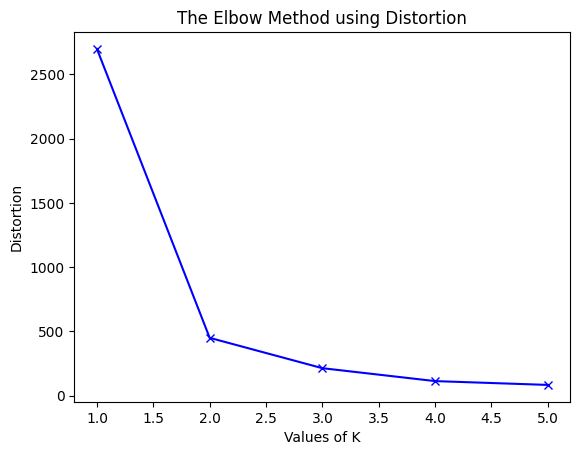

In [7]:
# Set a range for the possible number of clusters
ks = range(1, 6)
# Create an empty list to save the distortions
distortions=[]
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k,n_init='auto').fit(target_values_df)
    model.fit(target_values_df)
    distortions.append(sum(np.min(cdist(target_values_df, model.cluster_centers_,'euclidean'), axis=1)) / target_values_df.shape[0])

# Visualize the Elbow method graph    
plt.plot(ks, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

    

In [8]:
# Cluster the data based on the number of clusters from the elbow method
kmeans=KMeans(n_clusters=3,n_init='auto')
model=kmeans.fit(target_values_df)
target_values_df['Cluster']=kmeans.labels_

In [9]:
# The average value of each cluster
cluster_summary = target_values_df.groupby('Cluster').mean().round()
print(cluster_summary)

         p_t_hat
Cluster         
0          156.0
1         5966.0
2         2913.0


Against expectation, there is no zero-cluster.


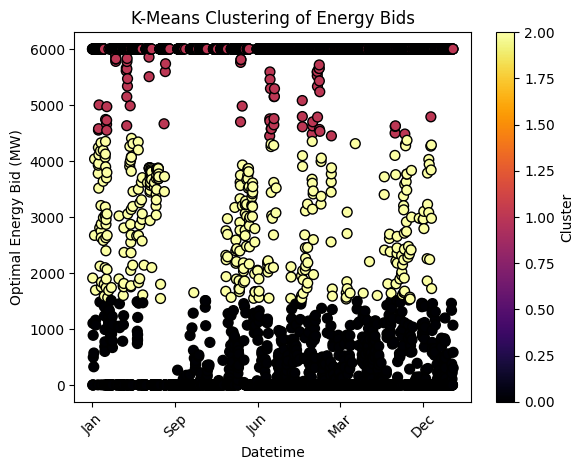

In [10]:
# Visualize the clusters
plt.scatter(target_values_df.index, target_values_df['p_t_hat'], c=target_values_df['Cluster'], s=50, edgecolors='black', cmap ='inferno')
plt.xlabel('Datetime', )
plt.ylabel('Optimal Energy Bid (MW)')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(MaxNLocator(6))  # Show only 10 date labels
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.title('K-Means Clustering of Energy Bids')
plt.colorbar(label='Cluster')
plt.show()

In [11]:
print(kmeans.cluster_centers_)

[[ 155.93770041]
 [5966.4579646 ]
 [2913.4005305 ]]


# Step 2

In [12]:
features = pd.read_csv('Data assignment 1/Features_Model2.csv')
features.rename(columns={'HourDK': 'DateTime'}, inplace=True)
features.set_index('DateTime', inplace=True)
features = features.drop('Unnamed: 0', axis=1)
scaler = StandardScaler()
features['actProd'] = scaler.fit_transform(features[['actProd']])
features.head()

,BalancingPriceUpEUR,BalancingPriceDownEUR,DA_PriceEUR,actProd
DateTime,,,,
2022-01-01 00:00:00,0.04660,0.04660,0.04660,0.289890
2022-01-01 01:00:00,0.04133,0.04133,0.04133,0.147976
2022-01-01 02:00:00,0.04218,0.04218,0.04218,0.916021
2022-01-01 03:00:00,0.04437,0.04437,0.04437,0.301554
2022-01-01 04:00:00,0.03767,0.03767,0.03767,-0.357754


In [21]:
target = pd.read_csv('Data assignment 1/TargetValues_Model2.csv')
target.rename(columns={'Unnamed: 0': 'DateTime'}, inplace=True)
target.set_index('DateTime', inplace=True)
scaler = StandardScaler()
target['p_t_hat'] = scaler.fit_transform(target[['p_t_hat']])
target.head()

,p_t_hat
DateTime,
2022-01-01 00:00:00,1.147345
2022-01-01 01:00:00,1.147345
2022-01-01 02:00:00,1.147345
2022-01-01 03:00:00,-0.318656
2022-01-01 04:00:00,-1.002552


### Regression
We will use regression to predict the target value since it can be seen that the target values can not be divided into distinct classes very well. Linear regression is most likely not complex enough, and it was shown that the least squares model for nonlinear regression showed the same results as linear regression. This is why the choice is now made to use polynomial nonlinear regression for model 2.

First determine the best degree used for polynomial nonlinear regression. The same code is used as for model 1.

In [22]:
# Define cross-validation function, which returns RMSE
def perform_cross_validation(X, y, degree, n_splits=10):
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(X)
    
    # Initialize linear regression model
    linear_model = LinearRegression()
    
    # Use KFold for cross-validation, n_splits set to 10
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Compute RMSE via cross-validation (use negative MSE and then take the square root)
    neg_mse_scores = cross_val_score(linear_model, X_poly, y, cv=kf, scoring='neg_mean_squared_error')
    
    # Convert negative MSE to RMSE
    rmse_scores = np.sqrt(-neg_mse_scores)
    
    # Return the mean RMSE
    return rmse_scores.mean()

In [23]:
# Polynomial degrees to evaluate: 2, 3, 4 and 5
degrees = [2, 3, 4, 5]
best_degree = None
best_rmse = float('inf')

# Perform cross-validation for each polynomial degree
for degree in degrees:
    print(f"Evaluating degree {degree} polynomial: ")
    rmse = perform_cross_validation(features, target, degree)
    print(f"Mean RMSE for degree {degree}: {rmse:.5f}")
    
    # Update the best model based on RMSE
    if rmse < best_rmse:
        best_rmse = rmse
        best_degree = degree

Evaluating degree 2 polynomial: 
Mean RMSE for degree 2: 0.82481
Evaluating degree 3 polynomial: 
Mean RMSE for degree 3: 0.81453
Evaluating degree 4 polynomial: 
Mean RMSE for degree 4: 0.78665
Evaluating degree 5 polynomial: 
Mean RMSE for degree 5: 1.03533


In [24]:
print(f"Best degree is {best_degree} with RMSE: {best_rmse:.5f}")


Best degree is 4 with RMSE: 0.78665


In [25]:
# Generate the best polynomial features
poly_best = PolynomialFeatures(degree=best_degree, include_bias=False)
X_poly_best = poly_best.fit_transform(features)

# Split the data into training and testing sets
X_train_poly_best, X_test_poly_best, y_train_poly_best, y_test_poly_best = train_test_split(
    X_poly_best, target.squeeze(), test_size=0.2, random_state=42)

# Train the final polynomial model
nonlinear_model_best = LinearRegression()
nonlinear_model_best.fit(X_train_poly_best, y_train_poly_best)

# Make predictions on the test set
y_pred_poly_best_test = nonlinear_model_best.predict(X_test_poly_best)

test_rmse_best = np.sqrt(mean_squared_error(y_test_poly_best, y_pred_poly_best_test))

# Evaluation
print(f"RMSE for Model 2 with degree {best_degree}: {test_rmse_best:.5f}")

RMSE for Model 2 with degree 4: 0.78289
